In [1]:
import os
import cx_Oracle
import pandas as pd
import numpy as np
import pickle
from datetime import date,datetime
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score 
import time
import matplotlib.pyplot as plt
from sklearn.utils import resample
import datetime
import sys
sys.path.append(R'C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Scoring Worlflow')

In [2]:
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\EMI and Tenure Estimation")

# Read Data File

In [3]:
# df1= pd.read_csv(os.getcwd()+"\Data Files\export1.csv")
# df2= pd.read_csv(os.getcwd()+"\Data Files\export2.csv")
# df3= pd.read_csv(os.getcwd()+"\Data Files\export3.csv")
# df4= pd.read_csv(os.getcwd()+"\Data Files\export4.csv")
# df_comb = pd.concat([df1,df2,df3,df4])

# df_comb.to_csv(os.getcwd()+"\Data Files\debt_estimate_combined.csv")

In [4]:
df_debt_est=pd.read_csv(os.getcwd()+"\Data Files\debt_estimate_combined.csv")

In [5]:
df_debt_est = df_debt_est[["SKP_CREDIT_CASE","ACTIVE_DEBT"]]

In [6]:
df= pd.read_pickle(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\Data Files\scored_income_2019_all_products.pkl")


In [7]:
df1 = pd.read_pickle(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\Data Files\combined_income_pred.pkl")

In [8]:
df1= df1[['SKP_CREDIT_CASE','CLIENT_DEBT', 'CLIENT_EMI','NTC_FLAG','PRODUCT_GROUP']]

In [9]:
df = df.merge(df1, on= 'SKP_CREDIT_CASE', how = 'inner')

In [10]:
df = df.merge(df_debt_est, on = 'SKP_CREDIT_CASE', how = 'inner')

# Create features for Analysis 

In [11]:
df.columns

Index(['SKP_CREDIT_CASE', 'TIME_DECISION_DATE', 'CUS_LAT', 'CUS_LONG',
       'RISK_FSTQPD30', 'GRID_ID', 'CLIENT_INR_INCOME', 'MONTH_STR',
       'PRED_INCOME', 'CLIENT_DEBT', 'CLIENT_EMI', 'NTC_FLAG', 'PRODUCT_GROUP',
       'ACTIVE_DEBT'],
      dtype='object')

In [12]:
df.columns= ['SKP_CREDIT_CASE', 'TIME_DECISION_DATE', 'CUS_LAT', 'CUS_LONG',
       'RISK_FSTQPD30', 'GRID_ID', 'REPORTED_INCOME',
       'MONTH_STR', 'PRED_INCOME', 'CLIENT_DEBT', 'CLIENT_EMI', 'NTC_FLAG','PRODUCT_GROUP','EST_DEBT']

In [13]:
features_list = ["EST_DTI_PRED_INCOME","EST_DTI_REPORTED_INCOME","EST_DTI_MIN_INCOME",'EST_DEBT']

In [14]:
df["MIN_INCOME"] = df[['REPORTED_INCOME','PRED_INCOME']].min(axis=1)

In [15]:
df["RATIO_PRED_REPORTED_INCOME"] = df['PRED_INCOME']/df['REPORTED_INCOME']

In [16]:
# df["DTI_PRED_INCOME"] = [(df["CLIENT_DEBT"][x]+ df["CLIENT_EMI"][x]+1500)/df["PRED_INCOME"][x] for x in df.index]
# df["DTI_REPORTED_INCOME"] = [(df["CLIENT_DEBT"][x]+ df["CLIENT_EMI"][x]+1500)/df["REPORTED_INCOME"][x] for x in df.index]
# df["DTI_MIN_INCOME"] = [(df["CLIENT_DEBT"][x]+ df["CLIENT_EMI"][x]+1500)/df["MIN_INCOME"][x] for x in df.index]
# df["EST_DTI_PRED_INCOME"] = [(df["EST_DEBT"][x]+ df["CLIENT_EMI"][x]+1500)/df["PRED_INCOME"][x] for x in df.index]
# df["EST_DTI_REPORTED_INCOME"] = [(df["EST_DEBT"][x]+ df["CLIENT_EMI"][x]+1500)/df["REPORTED_INCOME"][x] for x in df.index]
# df["EST_DTI_MIN_INCOME"] = [(df["EST_DEBT"][x]+ df["CLIENT_EMI"][x]+1500)/df["MIN_INCOME"][x] for x in df.index]


df["DTI_PRED_INCOME"] = (df["CLIENT_DEBT"]+ df["CLIENT_EMI"]+1500)/df["PRED_INCOME"]
df["DTI_REPORTED_INCOME"] =  (df["CLIENT_DEBT"]+ df["CLIENT_EMI"]+1500)/df["REPORTED_INCOME"]
df["DTI_MIN_INCOME"] =  (df["CLIENT_DEBT"]+ df["CLIENT_EMI"]+1500)/df["MIN_INCOME"]
df["EST_DTI_PRED_INCOME"] = (df["EST_DEBT"]+ df["CLIENT_EMI"]+1500)/df["PRED_INCOME"]
df["EST_DTI_REPORTED_INCOME"] = (df["EST_DEBT"]+ df["CLIENT_EMI"]+1500)/df["REPORTED_INCOME"]
df["EST_DTI_MIN_INCOME"] = (df["EST_DEBT"]+ df["CLIENT_EMI"]+1500)/df["MIN_INCOME"]


In [17]:
df.shape

(2178749, 22)

In [18]:
df = df[~df["MIN_INCOME"].isin([0,np.inf,np.nan])]

In [19]:
df.to_pickle(os.getcwd()+ "\Data Files\performance_file_bkp1.pkl")

In [20]:
df = pd.read_pickle(os.getcwd()+ "\Data Files\performance_file_bkp1.pkl")

In [21]:
df.dropna(subset=['EST_DEBT'], inplace= True)

# Gini and IV of Features for Comparison: All Products combined

In [22]:
df1=df

### Reduce sample size to reduce computation in calculations for IV, Gini

In [27]:
df = df1.sample(n=100000,random_state=2)

In [28]:
for x in features_list:
    df[x+"_BINS"] = pd.qcut(df[x],10,duplicates = 'drop')

In [29]:
df.dropna(subset=['EST_DEBT'], inplace= True)

In [45]:
from scoring.metrics import iv,gini
features_list1=["EST_DTI_PRED_INCOME","EST_DTI_REPORTED_INCOME","EST_DTI_MIN_INCOME",'EST_DEBT']
cols_list= features_list1
col_target= 'RISK_FSTQPD30'
power_tab = {'VARIABLE_NAME':[],'IV':[],'GINI':[]}
for j in range(0,len(cols_list)):
        power_tab["VARIABLE_NAME"].append(cols_list[j])
        power_tab["IV"].append("{:.3}".format(iv(df[col_target],df[cols_list[j]+"_BINS"])))
        power_tab["GINI"].append("{:.2%}".format(abs(2*metrics.roc_auc_score(df[col_target],df[cols_list[j]])-1)))
        print(cols_list[j])

EST_DTI_PRED_INCOME
EST_DTI_REPORTED_INCOME
EST_DTI_MIN_INCOME
EST_DEBT


In [46]:
power_out = pd.DataFrame(power_tab)

power_out = power_out.set_index('VARIABLE_NAME')
power_out = power_out.sort_values('GINI',ascending=False)

pd.options.display.max_rows = 1000
display(power_out)

power_out.to_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\gini_iv.csv")

,IV,GINI
VARIABLE_NAME,,
EST_DTI_PRED_INCOME,0.0363,9.57%
EST_DEBT,0.0547,12.11%
EST_DTI_MIN_INCOME,0.0386,10.49%
EST_DTI_REPORTED_INCOME,0.0365,10.41%


### To make MOM calculations of IV, GINI

In [50]:
from scoring.metrics import iv,gini,lift
cols_list= features_list
col_target= 'RISK_FSTQPD30'
power_tab = {'VARIABLE_NAME':[],'MONTH':[],'IV':[],'GINI':[]}
for j in range(0,len(cols_list)):
    for k in df.MONTH_STR.unique():
        power_tab["VARIABLE_NAME"].append(cols_list[j])
        power_tab["MONTH"].append(k)
        power_tab["IV"].append("{:.3}".format(iv(df[df.MONTH_STR==k][col_target],df[df.MONTH_STR==k][cols_list[j]+"_BINS"])))
        power_tab["GINI"].append("{:.1%}".format(abs(2*metrics.roc_auc_score(df[df.MONTH_STR==k][col_target],df[df.MONTH_STR==k][cols_list[j]])-1)))

In [51]:
power_out = pd.DataFrame(power_tab)
power_out = power_out.set_index('VARIABLE_NAME')
power_out = power_out.sort_values('GINI',ascending=False)

pd.options.display.max_rows = 1000
display(power_out)

power_out.to_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\mom_gini_iv.csv")

,MONTH,IV,GINI
VARIABLE_NAME,,,
EST_DTI_PRED_INCOME,2019-03,0.0477,9.4%
EST_DTI_MIN_INCOME,2019-03,0.0426,9.4%
EST_DEBT,2019-04,0.0393,9.3%
EST_DTI_REPORTED_INCOME,2019-05,0.0335,9.1%
EST_DTI_REPORTED_INCOME,2019-04,0.0367,9.0%
EST_DTI_MIN_INCOME,2019-07,0.0339,9.0%
EST_DTI_MIN_INCOME,2019-06,0.0374,8.9%
EST_DTI_REPORTED_INCOME,2019-07,0.0369,8.6%
EST_DTI_PRED_INCOME,2019-05,0.0273,8.5%


# Gini and IV of Features for Comparison: Product and NTC Bifur

### Reduce sample size to reduce computation in calculations for IV, Gini

In [68]:
x

'REPORTED_INCOME'

In [72]:
from scoring.metrics import iv,gini
cols_list= features_list
col_target= 'RISK_FSTQPD30'
power_tab = {'PRODUCT_GROUP':[],'NTC_FLAG':[],'VARIABLE_NAME':[],'IV':[],'GINI':[]}

for x in ['CD', 'CL','ACL']:
    for y in df1.NTC_FLAG.unique():
        df = df1[(df1.PRODUCT_GROUP==x)&(df1.NTC_FLAG==y)]
        df = df.sample(min(df.shape[0],100000),random_state=2)
        for z in features_list:
            df[z+"_BINS"] = pd.qcut(df[z],10,duplicates = 'drop')
        for j in range(0,len(cols_list)):
            power_tab["PRODUCT_GROUP"].append(x)
            power_tab["NTC_FLAG"].append(y)
            power_tab["VARIABLE_NAME"].append(cols_list[j])
            power_tab["IV"].append("{:.3}".format(iv(df[col_target],df[cols_list[j]+"_BINS"])))
            power_tab["GINI"].append("{:.2%}".format((2*metrics.roc_auc_score(df[col_target],df[cols_list[j]])-1)))
            print(cols_list[j])

REPORTED_INCOME
PRED_INCOME
MIN_INCOME
RATIO_PRED_REPORTED_INCOME
DTI_PRED_INCOME
DTI_REPORTED_INCOME
DTI_MIN_INCOME
EST_DTI_PRED_INCOME
EST_DTI_REPORTED_INCOME
EST_DTI_MIN_INCOME
EST_DEBT
REPORTED_INCOME
PRED_INCOME
MIN_INCOME
RATIO_PRED_REPORTED_INCOME
DTI_PRED_INCOME
DTI_REPORTED_INCOME
DTI_MIN_INCOME
EST_DTI_PRED_INCOME
EST_DTI_REPORTED_INCOME
EST_DTI_MIN_INCOME
EST_DEBT
REPORTED_INCOME
PRED_INCOME
MIN_INCOME
RATIO_PRED_REPORTED_INCOME
DTI_PRED_INCOME
DTI_REPORTED_INCOME
DTI_MIN_INCOME
EST_DTI_PRED_INCOME
EST_DTI_REPORTED_INCOME
EST_DTI_MIN_INCOME
EST_DEBT
REPORTED_INCOME
PRED_INCOME
MIN_INCOME
RATIO_PRED_REPORTED_INCOME
DTI_PRED_INCOME
DTI_REPORTED_INCOME
DTI_MIN_INCOME
EST_DTI_PRED_INCOME
EST_DTI_REPORTED_INCOME
EST_DTI_MIN_INCOME
EST_DEBT
REPORTED_INCOME
PRED_INCOME
MIN_INCOME
RATIO_PRED_REPORTED_INCOME
DTI_PRED_INCOME
DTI_REPORTED_INCOME
DTI_MIN_INCOME
EST_DTI_PRED_INCOME
EST_DTI_REPORTED_INCOME
EST_DTI_MIN_INCOME
EST_DEBT
REPORTED_INCOME
PRED_INCOME
MIN_INCOME
RATIO_PRED_REPOR

In [75]:
power_out = pd.DataFrame(power_tab)
power_out = power_out.set_index('VARIABLE_NAME')
power_out = power_out.sort_values('GINI',ascending=False)

pd.options.display.max_rows = 1000
display(power_out)

power_out.to_csv(os.getcwd()+ "\gini_iv.csv")

,PRODUCT_GROUP,NTC_FLAG,IV,GINI
VARIABLE_NAME,,,,
DTI_REPORTED_INCOME,CL,Others,0.0374,9.59%
EST_DTI_PRED_INCOME,CL,Others,0.0424,9.33%
EST_DTI_MIN_INCOME,ACL,NTC,0.223,8.89%
DTI_MIN_INCOME,CD,Others,0.0243,8.66%
REPORTED_INCOME,CL,Others,0.0233,8.02%
MIN_INCOME,CL,NTC,0.0781,7.90%
MIN_INCOME,CL,Others,0.019,7.56%
REPORTED_INCOME,ACL,Others,0.0243,7.56%
MIN_INCOME,ACL,Others,0.0203,7.49%


### To make MOM calculations of IV, GINI

In [ ]:
from scoring.metrics import iv,gini,lift
cols_list= features_list
col_target= 'RISK_FSTQPD30'
power_tab = {'VARIABLE_NAME':[],'MONTH':[],'IV':[],'GINI':[]}
for j in range(0,len(cols_list)):
    for k in df.MONTH_STR.unique():
        power_tab["VARIABLE_NAME"].append(j)
        power_tab["MONTH"].append(k)
        power_tab["IV"].append("{:.3}".format(iv(df[df.MONTH_STR==k][col_target],df[df.MONTH_STR==k][cols_list[j]+"_BINS"])))
        power_tab["GINI"].append("{:.1%}".format((2*metrics.roc_auc_score(df[df.MONTH_STR==k][col_target],df[df.MONTH_STR==k][cols_list[j]])-1)))

In [ ]:
power_out = pd.DataFrame(power_tab)
power_out = power_out.set_index('VARIABLE_NAME')
power_out = power_out.sort_values('Gini',ascending=False)

pd.options.display.max_rows = 1000
display(power_out)

power_out.to_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\mom_gini_iv.csv")

# WOE Analysis

In [68]:
df=df1
# Split Train and Test Data Set
df_train = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2019, 1, 1)) & 
              (df["TIME_DECISION_DATE"]<=datetime.datetime(2019, 3, 31))]
df_valid = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2019, 4, 1)) & 
              (df["TIME_DECISION_DATE"]<=datetime.datetime(2019, 5, 31))]
df_test = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2019, 6, 1)) & 
              (df["TIME_DECISION_DATE"]<=datetime.datetime(2019, 8, 31))]

In [69]:
cols_pred_num=features_list
cols_pred_cat = []

In [72]:
from scoring.grouping import Grouping

grouping = Grouping(columns = sorted(cols_pred_num),
                    cat_columns = sorted(cols_pred_cat),
                    group_count=4, 
                    min_samples=10000)

grouping.fit(df_train[cols_pred_num],
             df_train["RISK_FSTQPD30"],
          #   w=data[train_mask][col_weight],
            progress_bar=True, category_limit=10000);

grouping.save(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\my_grouping")

data_woe = grouping.transform(df, transform_to='woe', progress_bar=True)

'Grouping saved on 2020-04-08 18:08:12 to file C:\\Users\\aman.khatri91425\\Desktop\\HomeCredit\\Bigdata\\Common Maps KNN\\my_grouping'

### Plot Bins

***

### DTI_MIN_INCOME

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_DTI_MIN_INCOME,,,,,,,,
"[-inf, 0.2347)",29804.0,398.0,0.0134,0.1008,0.1947,0.6249,0.6586,0.1923
"[0.2347, 0.2978)",21337.0,396.0,0.0186,0.1003,0.1387,0.3102,0.3242,0.1377
"[0.2978, 0.4109)",38926.0,970.0,0.0249,0.2456,0.2513,0.0221,0.0230,0.2512
"[0.4109, inf)",64894.0,2185.0,0.0337,0.5533,0.4153,-0.2778,-0.2870,0.4188
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-3.6439,0.0000


IV: 0.1141
Gini: 17.50


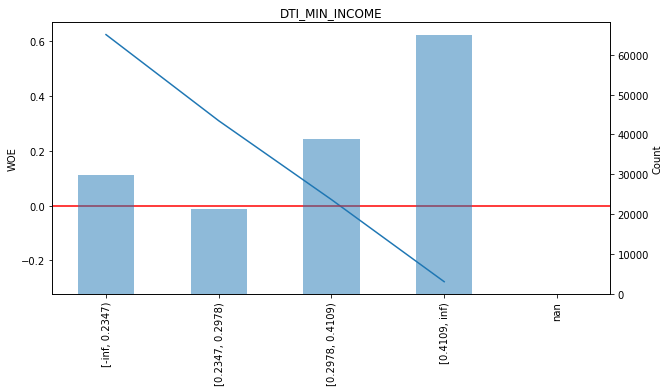

***

### DTI_PRED_INCOME

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_DTI_PRED_INCOME,,,,,,,,
"[-inf, 0.2504)",49501.0,705.0,0.0142,0.1785,0.3231,0.5639,0.5933,0.3194
"[0.2504, 0.326)",29147.0,642.0,0.0220,0.1626,0.1888,0.1434,0.1493,0.1881
"[0.326, 0.4078)",30923.0,865.0,0.0280,0.2190,0.1990,-0.0924,-0.0957,0.1996
"[0.4078, inf)",45390.0,1737.0,0.0383,0.4399,0.2891,-0.4071,-0.4198,0.2929
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-3.6439,0.0000


IV: 0.1549
Gini: 21.39


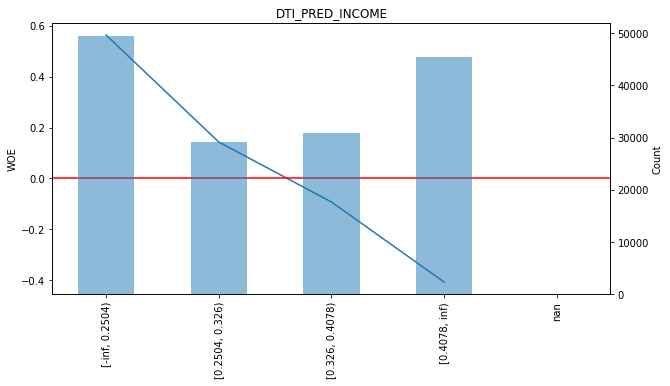

***

### DTI_REPORTED_INCOME

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_DTI_REPORTED_INCOME,,,,,,,,
"[-inf, 0.1744)",26588.0,448.0,0.0168,0.1134,0.1731,0.4034,0.4225,0.1716
"[0.1744, 0.2237)",20050.0,442.0,0.0220,0.1119,0.1298,0.1426,0.1485,0.1294
"[0.2237, 0.4346)",69700.0,1872.0,0.0269,0.4740,0.4492,-0.0520,-0.0539,0.4498
"[0.4346, inf)",38623.0,1187.0,0.0307,0.3006,0.2479,-0.1862,-0.1927,0.2492
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-3.6439,0.0000


IV: 0.0394
Gini: 9.97


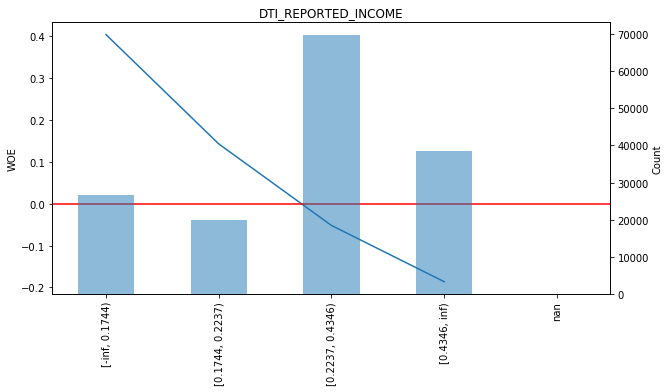

***

### MIN_INCOME

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_MIN_INCOME,,,,,,,,
"[-inf, 14035.2646)",36769.0,750.0,0.0204,0.1899,0.2385,0.2185,0.2278,0.2373
"[14035.2646, 17005.5166)",49211.0,1158.0,0.0235,0.2932,0.3182,0.0786,0.0817,0.3176
"[17005.5166, 19847.1104)",44185.0,1268.0,0.0287,0.3211,0.2842,-0.1178,-0.1221,0.2851
"[19847.1104, inf)",24796.0,773.0,0.0312,0.1957,0.1591,-0.2005,-0.2074,0.1600
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-3.6439,0.0000


IV: 0.0252
Gini: 8.76


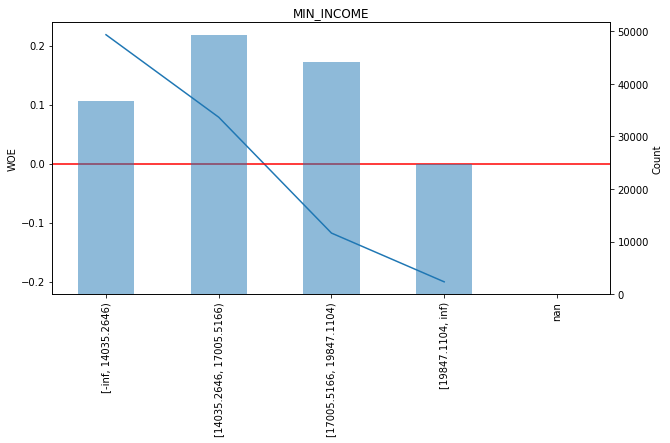

***

### PRED_INCOME

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_PRED_INCOME,,,,,,,,
"[-inf, 15302.4136)",14507.0,284.0,0.0196,0.0719,0.0942,0.2584,0.2697,0.0936
"[15302.4136, 17005.5166)",28910.0,668.0,0.0231,0.1692,0.1870,0.0965,0.1004,0.1866
"[17005.5166, 21082.085)",94249.0,2479.0,0.0263,0.6278,0.6077,-0.0313,-0.0325,0.6082
"[21082.085, inf)",17295.0,518.0,0.0300,0.1312,0.1111,-0.1605,-0.1661,0.1116
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-3.6439,0.0000


IV: 0.0118
Gini: 5.26


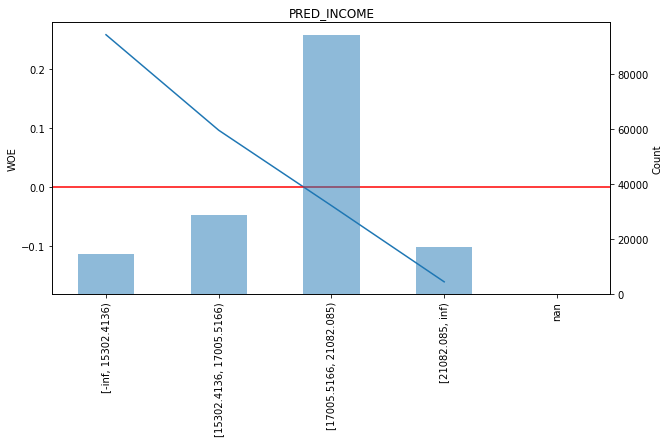

***

### RATIO_PRED_REPORTED_INCOME

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_RATIO_PRED_REPORTED_INCOME,,,,,,,,
"[-inf, 0.5827)",22075.0,711.0,0.0322,0.1800,0.1415,-0.2332,-0.2411,0.1425
"[0.5827, 0.7794)",26004.0,759.0,0.0292,0.1922,0.1672,-0.1347,-0.1395,0.1678
"[0.7794, 1.2544)",64248.0,1590.0,0.0247,0.4026,0.4149,0.0289,0.0301,0.4146
"[1.2544, inf)",42634.0,889.0,0.0209,0.2251,0.2764,0.1970,0.2053,0.2751
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-3.6439,0.0000


IV: 0.0237
Gini: 8.44


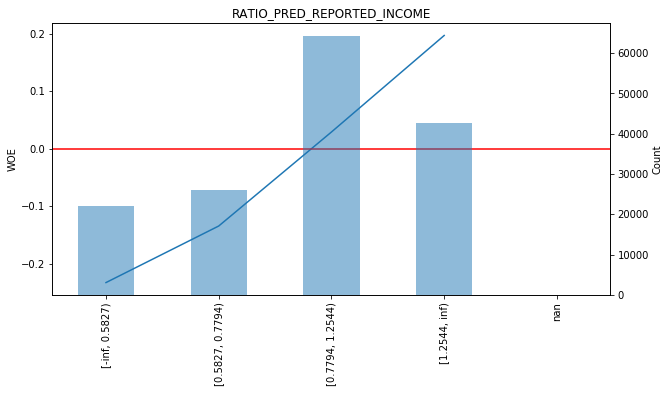

***

### REPORTED_INCOME

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_REPORTED_INCOME,,,,,,,,
"[-inf, 17999.9004)",67598.0,1451.0,0.0215,0.3674,0.4380,0.1687,0.1757,0.4362
"[17999.9004, 28599.7002)",54869.0,1436.0,0.0262,0.3636,0.3538,-0.0263,-0.0273,0.3541
"[28599.7002, 35050.0)",18162.0,623.0,0.0343,0.1578,0.1161,-0.2965,-0.3063,0.1172
"[35050.0, inf)",14332.0,439.0,0.0306,0.1112,0.0920,-0.1829,-0.1893,0.0925
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-3.6439,0.0000


IV: 0.0290
Gini: 9.17


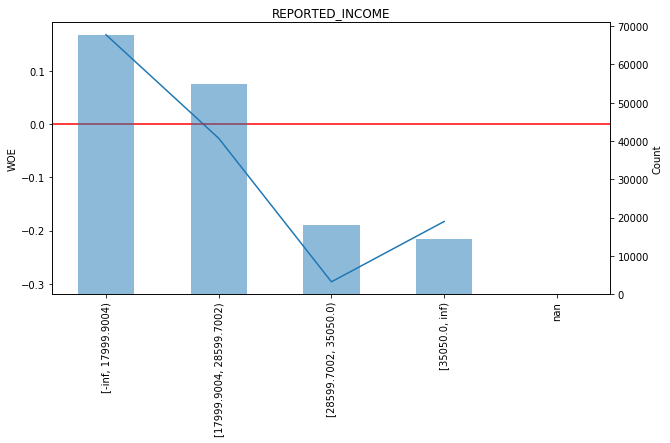

In [73]:
grouping.plot_bins(data=df_train, cols_pred_num=cols_pred_num, cols_pred_cat=cols_pred_cat,
                    mask = pd.Series(df_train["REPORTED_INCOME"]>=0),col_target="RISK_FSTQPD30", 
                   output_folder=r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN", col_weight=None)

In [152]:
woe_columns_to_replace = list()
for column in data_woe.columns:
    if column in df:
        woe_columns_to_replace.append(column)
        print('Column', column ,'dropped as it already existed in the data set.')
df = df.drop(woe_columns_to_replace, axis='columns')
df = df.join(-data_woe)

print('Added WOE variables. Number of columns:',df.shape[1])
cols_woe = [s + '_WOE' for s in cols_pred_num]

Added WOE variables. Number of columns: 25


# MOM R Square

In [60]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score 

In [61]:
dic= {"MONTH_STR":[],"RMSE":[],"R_SQUARED":[]}
for x in df.MONTH_STR.unique():
    dic["MONTH_STR"].append(x)
    dic["RMSE"].append(round(np.sqrt(mse(df[df.MONTH_STR==x]["REPORTED_INCOME"],df[df.MONTH_STR==x]["PRED_INCOME"]))))
    dic["R_SQUARED"].append(r2_score(df[df.MONTH_STR==x]["REPORTED_INCOME"],df[df.MONTH_STR==x]["PRED_INCOME"]))
    
r_sq_df = pd.DataFrame(dic)

r_sq_df

,MONTH_STR,RMSE,R_SQUARED
0,2019-01,10124.0,-0.047347
1,2019-02,10249.0,-0.043667
2,2019-03,10228.0,-0.038922
3,2019-04,10250.0,-0.051328
4,2019-05,10293.0,-0.059323
5,2019-06,10518.0,-0.064425
6,2019-07,10418.0,-0.047537
7,2019-08,10299.0,-0.044807


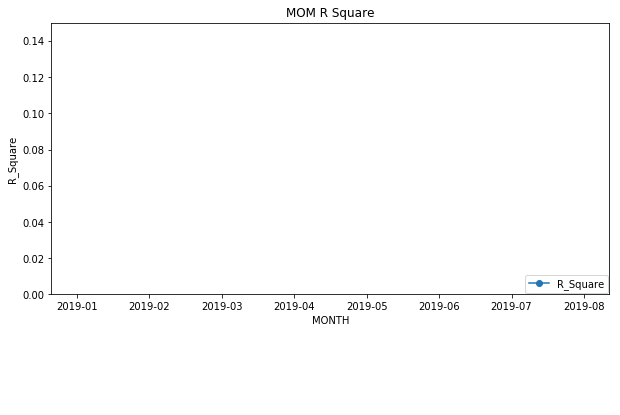

In [62]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1,1,1)

ax1.plot(r_sq_df["MONTH_STR"],r_sq_df["R_SQUARED"], marker = 'o', label = 'R_Square')

for i, txt in enumerate(r_sq_df["R_SQUARED"]):
    plt.annotate("{:.2f}".format(txt), (r_sq_df["MONTH_STR"][i], r_sq_df["R_SQUARED"][i]+0.003))

plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(0,0.15)
plt.ylabel("R_Square")
plt.xlabel("MONTH")
ax1.set_title("MOM R Square")
plt.show()